In [268]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate, QFT

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
pi = np.pi

In [293]:
def create_hamiltonian(qubits, g, quiet=False):
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)

    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    if not quiet: print("H = ", end='')
    for i in range(qubits-1):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(temp)+" ", end='')
        H += -temp.to_matrix()
    for i in range(qubits):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(g)+"*"+str(temp)+" ", end='')
        H += -g*temp.to_matrix()
    if not quiet: print("\n")
    
    scale_factor = 1
    # normalize the Hamiltonian
    H = scale_factor*H/np.linalg.norm(H, ord=2)
    
    # # rotate matrix so that it will be positive definite
    # H += np.eye(2**qubits)

    if not quiet: print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
    min_eigenvalue = np.min(np.linalg.eigvals(H))
    if not quiet: print("Lowest energy Eigenvalue", min_eigenvalue); print()

    return H

def ht(ham, t, W = 'Re'):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(Ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    # qc.h(qr_eigenstate)
    mat = expm(1j*Ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0] == 'I': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 1000
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/Nsample
    meas = 2*p0-1
    return meas

def run_hadamard_test(ham, t):
    Re = ht(ham, t, W = 'Re')
    Im = ht(ham, t, W = 'Im')
    print(Re, Im)
    phase = math.acos(Re)
    if Im<0: # asin(Im)
        phase = -phase
    return phase


In [ ]:
print(run_hadamard_test([[1,0],[0, 1j*2]], 1))

0.53 -0.864
-1.0121957614520958


In [270]:
data_points = 100
t_list = np.linspace(0, 2*pi, data_points)
# print(t_list)
Ham = create_hamiltonian(2,0)
phases = []
for t in t_list:
    # if t == 0: continue
    phase = run_hadamard_test(Ham, t)
    # phase = phase/t
    phases.append(phase)
    print("phase is", phase)


H = -ZZ -0*XI -0*IX 

Eigenvalues of the Hamiltonian:
 [-1.+0.j  1.+0.j  1.+0.j -1.+0.j]
Lowest energy Eigenvalue (-1+0j)

1.0 -0.0020000000000000018
phase is -0.0
1.0 -0.04400000000000004
phase is -0.0
0.99 -0.09199999999999997
phase is -0.1415394733244273
0.982 -0.15600000000000003
phase is -0.1900224234627107
0.976 -0.22999999999999998
phase is -0.2195295842499295
0.94 -0.31000000000000005
phase is -0.34816602127296103
0.9319999999999999 -0.33999999999999997
phase is -0.37090417752027244
0.8999999999999999 -0.41400000000000003
phase is -0.45102681179626264
0.8759999999999999 -0.43200000000000005
phase is -0.5032910474523903
0.8300000000000001 -0.532
phase is -0.5916886424265438
0.8260000000000001 -0.636
phase is -0.5988223387390885
0.748 -0.648
phase is -0.725752802353242
0.698 -0.642
phase is -0.7981955606003048
0.6539999999999999 -0.742
phase is -0.8579363494812755
0.6399999999999999 -0.766
phase is -0.8762980611683407
0.5740000000000001 -0.838
phase is -0.9594139191942418
0.542 -

In [271]:
print(create_hamiltonian(2,0))
mat = expm(-1j*Ham*2*pi)
print(mat)

H = -ZZ -0*XI -0*IX 

Eigenvalues of the Hamiltonian:
 [-1.+0.j  1.+0.j  1.+0.j -1.+0.j]
Lowest energy Eigenvalue (-1+0j)

[[-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]
[[1.-2.4492936e-16j 0.+0.0000000e+00j 0.+0.0000000e+00j 0.+0.0000000e+00j]
 [0.+0.0000000e+00j 1.+2.4492936e-16j 0.+0.0000000e+00j 0.+0.0000000e+00j]
 [0.+0.0000000e+00j 0.+0.0000000e+00j 1.+2.4492936e-16j 0.+0.0000000e+00j]
 [0.+0.0000000e+00j 0.+0.0000000e+00j 0.+0.0000000e+00j 1.-2.4492936e-16j]]


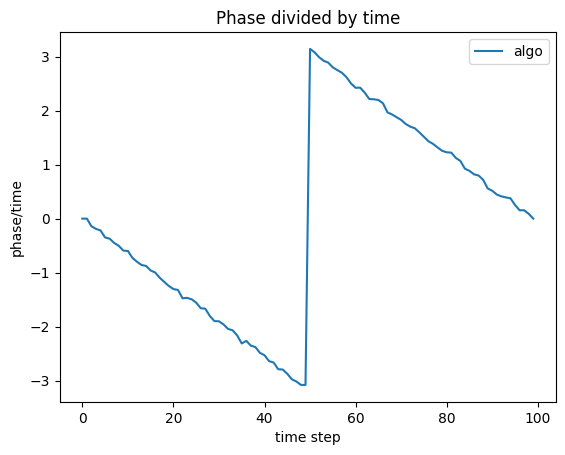

In [272]:
real_phase = [np.linalg.eigvals(Ham)[0].real for _ in range(data_points)]
plt.title("Phase divided by time")
plt.xlabel("time step")
plt.ylabel("phase/time")
plt.plot(phases, label = "algo")
# plt.plot(real_phase, label = "expected")
plt.legend()
plt.show()

In [275]:
def generate_s_k(ham, k, Dt, K):
    # use real hadmard test to generate data
    s_k = [0 for _ in range(2*K+1)]
    for i in range(2*K+1):
        # print("generating s_k for Dt:", (i+1)*Dt)
        s_k[i] = run_hadamard_test(ham, (i+1)*Dt)
    # print(s_k)
    # s_k = [1,0,-1,0,1,0,-1,0,1]
    return s_k

def make_X(start, K, d, s_k = []):
    X = np.zeros((d, K+1))
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] = s_k[i+j+start]
    return X

def least_squares_regularization(X, noise_threshold):
    # print("X", X)
    U, sigma, V = np.linalg.svd(X)
    threshold = noise_threshold*max(sigma)
    # print("U", U)
    # print("sigma", sigma)
    # print("V", V)
    for l in range(len(sigma)):
        # print("iteration")
        # print("sigma_l", sigma[l])
        if sigma[l] <= threshold:
            # print("    too small\n")
            sigma[l] = 0
            U[:,l] = 0
            V[:,l] = 0
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    # print("U\n", U)
    # print("sigma\n", sigma_mat)
    # print("V\n", V.conj().T)
    return U @ sigma_mat @ V.conj().T

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''

def ODMD(ham, Dt, noise_threshold, err_threshold, K = 3, alpha = 1/2, est_E_0s = []): 
    k = 0
    # this is the suggested formula
    # d = math.floor(alpha*(K+1))
    d=3
    old_E_0 = 10000
    while (True):
        if k*Dt > 2*pi: print("didn't work"); break
        print("k =", k)
        s_k = generate_s_k(ham, k, Dt, K)
        X = make_X(0, K, d, s_k=s_k)
        print("X\n",X)
        Xprime = make_X(1, K, d, s_k=s_k)
        print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        print("X_sigma\n",X_sigma)  
        A = Xprime @ np.linalg.pinv(X_sigma)
        print("A\n",A)  
        k = k+1
        eigenvalues,_ = np.linalg.eig(A)
        print("eigenvalues\n", eigenvalues)
        # plt.plot(eigenvalues)
        # plt.show()
        # I don't know if I am doing this right (I log?)
        # eigenlogs = [math.atan2(i.imag, i.real) for i in eigenvalues]
        # for i in range(len(eigenlogs)):
        #     if eigenlogs[i] == pi: eigenlogs[i] = 0.0
        # print("eigenlogs\n", eigenlogs)
        # plt.plot(eigenlogs)
        # plt.show()
        eigenmax = max(eigenvalues, key=abs)
        print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        print("angle =", angle)
        E_0 = angle/Dt
        est_E_0s.append(E_0)
        print("E_0 =", E_0)
        if abs(old_E_0 - E_0) < err_threshold: break
        old_E_0 = E_0
    return E_0

Ham = create_hamiltonian(2, 0)

# Ham = np.array([[1,0],[0,-1]])
eigenvalues,_ = np.linalg.eig(Ham)
# print(Ham)
# print(eigenvalues)
# plt.plot(eigenvalues)
# plt.show()
est_E_0s = []
# Dt = 2*pi/((eigenvalues[-1].real-eigenvalues[0].real)+(eigenvalues[1].real-eigenvalues[0].real))
# print(Dt)
ODMD(Ham, pi/1, .1, 0.0001, est_E_0s = est_E_0s)

# for Dt in np.linspace(0.1,2*pi, 10):
#     print(ODMD(Ham, Dt, 0.001, 0.001))

H = -ZZ -0*XI -0*IX 

Eigenvalues of the Hamiltonian:
 [-1.+0.j  1.+0.j  1.+0.j -1.+0.j]
Lowest energy Eigenvalue (-1+0j)

k = 0
-1 0.0020000000000000018
1.0 0.0020000000000000018
-1 -0.006000000000000005
1.0 -0.08799999999999997
-1 0.020000000000000018
1.0 -0.016000000000000014
-1 0.006000000000000005
X
 [[ 3.14159265  0.         -3.14159265 -0.        ]
 [ 0.         -3.14159265 -0.          3.14159265]
 [-3.14159265 -0.          3.14159265 -0.        ]]
Xprime
 [[ 0.         -3.14159265 -0.          3.14159265]
 [-3.14159265 -0.          3.14159265 -0.        ]
 [-0.          3.14159265 -0.          3.14159265]]
X_sigma
 [[ 3.14159265  0.         -3.14159265  0.        ]
 [ 0.         -3.14159265  0.         -3.14159265]
 [-3.14159265  0.          3.14159265  0.        ]]
A
 [[ 0.00000000e+00 -3.56036267e-18  0.00000000e+00]
 [-5.00000000e-01  0.00000000e+00  5.00000000e-01]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00]]
eigenvalues
 [ 1.71602541e-158+0.j         -5.55111512e-0

0.5

[0.5000000000000001, 0.5]


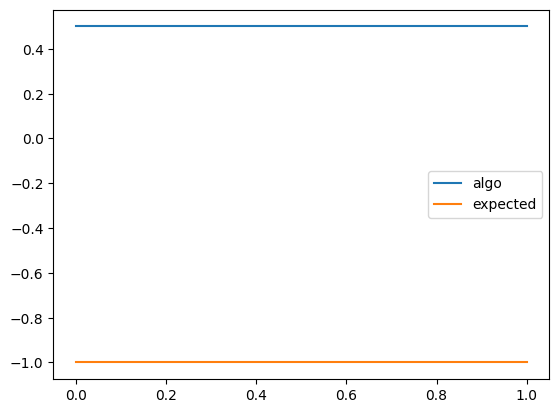

In [276]:
real_E_0 = [np.linalg.eigvals(Ham)[0].real for _ in range(len(est_E_0s))]
avg_E_0 = [np.average(est_E_0s) for _ in range(len(est_E_0s))]
print(est_E_0s)
test = np.array(est_E_0s)

plt.plot(est_E_0s, label = "algo")
# plt.plot(avg_E_0, label = "algo avg")
plt.plot(real_E_0, label = "expected")
plt.legend()
plt.show()